In [2]:
# Input a 2D pollutied data set within normal distributed noise.



# Dataset pre-treatment
## Import and draw
(The data has polluted in three parts: background, position(x and y coordinate) and value noise(the dependent number))

<IPython.core.display.Javascript object>


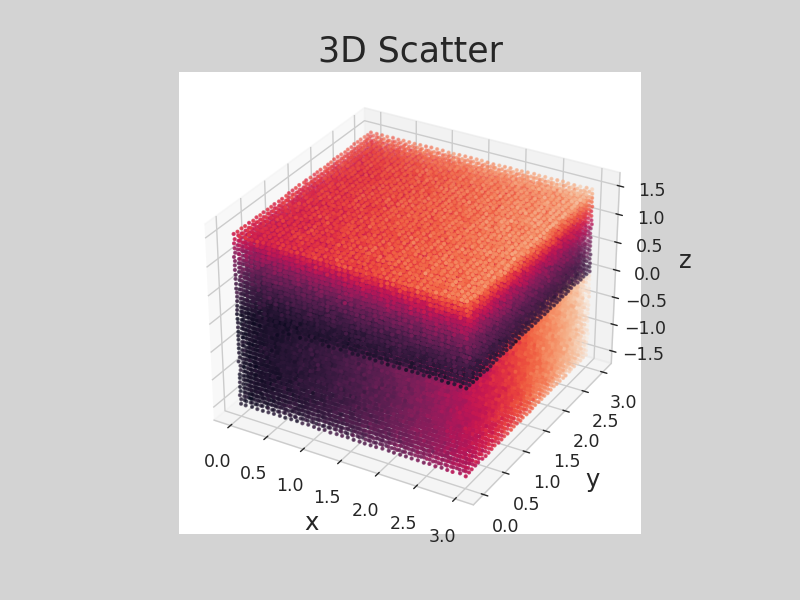

1600


In [36]:
%reset -f
%clear
import numpy as np
import copy
import matplotlib.pyplot as plt 
plt.close('all')
import scipy.io as scio
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import scipy.stats as stats
import math
from numba import jit # Accelerator
from scipy.spatial import Voronoi, ConvexHull
from sklearn.neighbors import KDTree, KernelDensity
from sklearn.model_selection import GridSearchCV
import platform
import time
import gc
import seaborn as sns

# Data + 0.05 Standard error
DataX = scio.loadmat('PollutedPositionX_3D.mat')
DataX = DataX['PositionXP']
DataY = scio.loadmat('PollutedPositionY_3D.mat')
DataY = DataY['PositionYP']
DataZ = scio.loadmat('PollutedPositionZ_3D.mat')
DataZ = DataZ['PositionZP']
DataF = scio.loadmat('PollutedData_3D.mat')
DataF = DataF['DataOutP']

# Origin data
# DataX = scio.loadmat('PositionX_3D.mat')
# DataX = DataX['N1']
# DataY = scio.loadmat('PositionY_3D.mat')
# DataY = DataY['N2']
# DataZ = scio.loadmat('PositionZ_3D.mat')
# DataZ = DataZ['N3']
# DataF = scio.loadmat('Data_3D.mat')
# DataF = DataF['DataOut']

%matplotlib notebook
plt.figure("3D Scatter", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('3D Scatter', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)

ax3d.scatter(DataX, DataY, DataZ, c = DataF,s = 2)
plt.show()

NoPs = 40 * 40 # Points in one outend surface
print(NoPs)

# Import data and draw.

## Trimming Voronoi cell
The rige of our data field out of our boundary even tend to infinity, when 
apply the packed voronoi cell generation algorithm. Though, by now we got to trim off the 
exceeded points and make sure the polygon keep convex.

In [122]:
# Temporary parameter for boundary reflection
X_mid = (max(DataX) - min(DataX))/2 + min(DataX)
Y_mid = (max(DataY) - min(DataY))/2 + min(DataY)
Z_mid = (max(DataZ) - min(DataZ))/2 + min(DataZ)

#Xmin Y-Z plane
DataX_Xmin_Ori = copy.deepcopy(DataX)
DataY_Xmin_Ori = copy.deepcopy(DataY)
DataZ_Xmin_Ori = copy.deepcopy(DataZ)
DataF_Xmin_Ori = copy.deepcopy(DataF)

XMinx_Frame = np.zeros((NoPs,1))
XMiny_Frame = np.zeros((NoPs,1))
XMinz_Frame = np.zeros((NoPs,1))
XMinx_M1 = np.zeros((NoPs,1))
XMiny_M1 = np.zeros((NoPs,1))
XMinz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataX_Xmin_Ori.argmin()
    XMinx_Frame[PtN] = DataX_Xmin_Ori[PT_temp]
    XMiny_Frame[PtN] = DataY_Xmin_Ori[PT_temp]
    XMinz_Frame[PtN] = DataZ_Xmin_Ori[PT_temp]

    DataX_Xmin_Ori[PT_temp] = X_mid
    DataY_Xmin_Ori[PT_temp] = Y_mid
    DataZ_Xmin_Ori[PT_temp] = Z_mid

# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataX_Xmin_Ori.argmin()
    XMinx_M1[PtN] = DataX_Xmin_Ori[PT_temp]
    XMiny_M1[PtN] = DataY_Xmin_Ori[PT_temp]
    XMinz_M1[PtN] = DataZ_Xmin_Ori[PT_temp]

# Cutting Reflection
XMinx_FrameR = -1 * XMinx_Frame
Xmin_Offset = np.abs(np.mean(XMinx_Frame - XMinx_M1))
Xmin_GAP = np.abs(np.mean(XMinx_Frame - XMinx_FrameR))
XMinx_CR = XMinx_FrameR + Xmin_GAP - Xmin_Offset 

DataX_xmin_DONE = np.vstack((DataX, XMinx_CR))
DataY_xmin_DONE = np.vstack((DataY, XMiny_Frame))
DataZ_xmin_DONE = np.vstack((DataZ, XMinz_Frame))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

#Zmin X-Y plane
NoPs = 1640
DataX_Zmin_Ori = copy.deepcopy(DataX_xmin_DONE)
DataY_Zmin_Ori = copy.deepcopy(DataY_xmin_DONE)
DataZ_Zmin_Ori = copy.deepcopy(DataZ_xmin_DONE)

ZMinx_Frame = np.zeros((NoPs,1))
ZMiny_Frame = np.zeros((NoPs,1))
ZMinz_Frame = np.zeros((NoPs,1))
ZMinx_M1 = np.zeros((NoPs,1))
ZMiny_M1 = np.zeros((NoPs,1))
ZMinz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataZ_Zmin_Ori.argmin()
    ZMinx_Frame[PtN] = DataX_Zmin_Ori[PT_temp]
    ZMiny_Frame[PtN] = DataY_Zmin_Ori[PT_temp]
    ZMinz_Frame[PtN] = DataZ_Zmin_Ori[PT_temp]

    DataX_Zmin_Ori[PT_temp] = X_mid
    DataY_Zmin_Ori[PT_temp] = Y_mid
    DataZ_Zmin_Ori[PT_temp] = Z_mid


# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataZ_Zmin_Ori.argmin()
    ZMinx_M1[PtN] = DataX_Zmin_Ori[PT_temp]
    ZMiny_M1[PtN] = DataY_Zmin_Ori[PT_temp]
    ZMinz_M1[PtN] = DataZ_Zmin_Ori[PT_temp]

# Cutting Reflection
ZMinz_FrameR = -1 * ZMinz_Frame
Zmin_Offset = np.abs(np.mean(ZMinz_Frame - ZMinz_M1))
Zmin_GAP = np.abs(np.mean(ZMinz_Frame - ZMinz_FrameR))
ZMinz_CR = ZMinz_FrameR - Zmin_GAP - Zmin_Offset

DataX_Zmin_DONE = np.vstack((DataX_xmin_DONE, ZMinx_Frame))
DataY_Zmin_DONE = np.vstack((DataY_xmin_DONE, ZMiny_Frame))
DataZ_Zmin_DONE = np.vstack((DataZ_xmin_DONE, ZMinz_CR))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

#Ymin X-Z plane
NoPs = 1681
DataX_Ymin_Ori = copy.deepcopy(DataX_Zmin_DONE)
DataY_Ymin_Ori = copy.deepcopy(DataY_Zmin_DONE)
DataZ_Ymin_Ori = copy.deepcopy(DataZ_Zmin_DONE)

YMinx_Frame = np.zeros((NoPs,1))
YMiny_Frame = np.zeros((NoPs,1))
YMinz_Frame = np.zeros((NoPs,1))
YMinx_M1 = np.zeros((NoPs,1))
YMiny_M1 = np.zeros((NoPs,1))
YMinz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataY_Ymin_Ori.argmin()
    YMinx_Frame[PtN] = DataX_Ymin_Ori[PT_temp]
    YMiny_Frame[PtN] = DataY_Ymin_Ori[PT_temp]
    YMinz_Frame[PtN] = DataZ_Ymin_Ori[PT_temp]

    DataX_Ymin_Ori[PT_temp] = X_mid
    DataY_Ymin_Ori[PT_temp] = Y_mid
    DataZ_Ymin_Ori[PT_temp] = Z_mid

# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataY_Ymin_Ori.argmin()
    YMinx_M1[PtN] = DataX_Ymin_Ori[PT_temp]
    YMiny_M1[PtN] = DataY_Ymin_Ori[PT_temp]
    YMinz_M1[PtN] = DataZ_Ymin_Ori[PT_temp]

# Cutting Reflection
YMiny_FrameR = -1 * YMiny_Frame
Ymin_Offset = np.abs(np.mean(YMiny_Frame - YMiny_M1))
Ymin_GAP = np.abs(np.mean(YMiny_Frame - YMiny_FrameR))
YMiny_CR = YMiny_FrameR + Ymin_GAP - Ymin_Offset

DataX_Ymin_DONE = np.vstack((DataX_Zmin_DONE, YMinx_Frame))
DataY_Ymin_DONE = np.vstack((DataY_Zmin_DONE, YMiny_CR))
DataZ_Ymin_DONE = np.vstack((DataZ_Zmin_DONE, YMinz_Frame))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

#Xmax Y-Z plane
NoPs = 1681
DataX_Xmax_Ori = copy.deepcopy(DataX_Ymin_DONE)
DataY_Xmax_Ori = copy.deepcopy(DataY_Ymin_DONE)
DataZ_Xmax_Ori = copy.deepcopy(DataZ_Ymin_DONE)

XMaxx_Frame = np.zeros((NoPs,1))
XMaxy_Frame = np.zeros((NoPs,1))
XMaxz_Frame = np.zeros((NoPs,1))
XMaxx_M1 = np.zeros((NoPs,1))
XMaxy_M1 = np.zeros((NoPs,1))
XMaxz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataX_Xmax_Ori.argmax()
    XMaxx_Frame[PtN] = DataX_Xmax_Ori[PT_temp]
    XMaxy_Frame[PtN] = DataY_Xmax_Ori[PT_temp]
    XMaxz_Frame[PtN] = DataZ_Xmax_Ori[PT_temp]

    DataX_Xmax_Ori[PT_temp] = X_mid
    DataY_Xmax_Ori[PT_temp] = Y_mid
    DataZ_Xmax_Ori[PT_temp] = Z_mid


# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataX_Xmax_Ori.argmax()
    XMaxx_M1[PtN] = DataX_Xmax_Ori[PT_temp]
    XMaxy_M1[PtN] = DataY_Xmax_Ori[PT_temp]
    XMaxz_M1[PtN] = DataZ_Xmax_Ori[PT_temp]

# Cutting Reflection
XMaxx_FrameR = -1 * XMaxx_Frame
Xmax_Offset = np.abs(np.mean(XMaxx_Frame - XMaxx_M1))
Xmax_GAP = np.abs(np.mean(XMaxx_Frame - XMaxx_FrameR))
XMaxx_CR = XMaxx_FrameR + Xmax_GAP + Xmax_Offset

DataX_Xmax_DONE = np.vstack((DataX_Ymin_DONE, XMaxx_CR))
DataY_Xmax_DONE = np.vstack((DataY_Ymin_DONE, XMaxy_Frame))
DataZ_Xmax_DONE = np.vstack((DataZ_Ymin_DONE, XMaxz_Frame))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

#Ymax X-Z plane
NoPs = 1722
DataX_Ymax_Ori = copy.deepcopy(DataX_Xmax_DONE)
DataY_Ymax_Ori = copy.deepcopy(DataY_Xmax_DONE)
DataZ_Ymax_Ori = copy.deepcopy(DataZ_Xmax_DONE)

YMaxx_Frame = np.zeros((NoPs,1))
YMaxy_Frame = np.zeros((NoPs,1))
YMaxz_Frame = np.zeros((NoPs,1))
YMaxx_M1 = np.zeros((NoPs,1))
YMaxy_M1 = np.zeros((NoPs,1))
YMaxz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataY_Ymax_Ori.argmax()
    YMaxx_Frame[PtN] = DataX_Ymax_Ori[PT_temp]
    YMaxy_Frame[PtN] = DataY_Ymax_Ori[PT_temp]
    YMaxz_Frame[PtN] = DataZ_Ymax_Ori[PT_temp]

    DataX_Ymax_Ori[PT_temp] = X_mid
    DataY_Ymax_Ori[PT_temp] = Y_mid
    DataZ_Ymax_Ori[PT_temp] = Z_mid


# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataY_Ymax_Ori.argmax()
    YMaxx_M1[PtN] = DataX_Ymax_Ori[PT_temp]
    YMaxy_M1[PtN] = DataY_Ymax_Ori[PT_temp]
    YMaxz_M1[PtN] = DataZ_Ymax_Ori[PT_temp]

# Cutting Reflection
YMaxy_FrameR = -1 * YMaxy_Frame
Ymax_Offset = np.abs(np.mean(YMaxy_Frame - YMaxy_M1))
Ymax_GAP = np.abs(np.mean(YMaxy_Frame - YMaxy_FrameR))
YMaxy_CR = YMaxy_FrameR + Ymax_GAP + Ymax_Offset

DataX_Ymax_DONE = np.vstack((DataX_Xmax_DONE, YMaxx_Frame))
DataY_Ymax_DONE = np.vstack((DataY_Xmax_DONE, YMaxy_CR))
DataZ_Ymax_DONE = np.vstack((DataZ_Xmax_DONE, YMaxz_Frame))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

#Zmax X-Y plane
NoPs = 1764
DataX_Zmax_Ori = copy.deepcopy(DataX_Ymax_DONE)
DataY_Zmax_Ori = copy.deepcopy(DataY_Ymax_DONE)
DataZ_Zmax_Ori = copy.deepcopy(DataZ_Ymax_DONE)

ZMaxx_Frame = np.zeros((NoPs,1))
ZMaxy_Frame = np.zeros((NoPs,1))
ZMaxz_Frame = np.zeros((NoPs,1))
ZMaxx_M1 = np.zeros((NoPs,1))
ZMaxy_M1 = np.zeros((NoPs,1))
ZMaxz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataZ_Zmax_Ori.argmax()
    ZMaxx_Frame[PtN] = DataX_Zmax_Ori[PT_temp]
    ZMaxy_Frame[PtN] = DataY_Zmax_Ori[PT_temp]
    ZMaxz_Frame[PtN] = DataZ_Zmax_Ori[PT_temp]

    DataX_Zmax_Ori[PT_temp] = X_mid
    DataY_Zmax_Ori[PT_temp] = Y_mid
    DataZ_Zmax_Ori[PT_temp] = Z_mid

# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataZ_Zmax_Ori.argmax()
    ZMaxx_M1[PtN] = DataX_Zmax_Ori[PT_temp]
    ZMaxy_M1[PtN] = DataY_Zmax_Ori[PT_temp]
    ZMaxz_M1[PtN] = DataZ_Zmax_Ori[PT_temp]

# Cutting Reflection
ZMaxz_FrameR = -1 * ZMaxz_Frame
Zmax_Offset = np.abs(np.mean(ZMaxz_Frame - ZMaxz_M1))
Zmax_GAP = np.abs(np.mean(ZMaxz_Frame - ZMaxz_FrameR))
ZMaxz_CR = ZMaxz_FrameR + Zmax_GAP + Zmax_Offset

DataX_Zmax_DONE = np.vstack((DataX_Ymax_DONE, ZMaxx_Frame))
DataY_Zmax_DONE = np.vstack((DataY_Ymax_DONE, ZMaxy_Frame))
DataZ_Zmax_DONE = np.vstack((DataZ_Ymax_DONE, ZMaxz_CR))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

# Show points cloud and reflected boundary
Data3D_x = copy.deepcopy(DataX_Zmax_DONE)
Data3D_y = copy.deepcopy(DataY_Zmax_DONE)
Data3D_z = copy.deepcopy(DataZ_Zmax_DONE)
Data3D = np.hstack((Data3D_x, Data3D_y, Data3D_z))
type(Data3D)

vor = Voronoi(Data3D)
vor_vertices = copy.deepcopy(vor.vertices)
vor_regions = copy.deepcopy(vor.regions)

# The crude votonoi cell, the boundary was tend to infinity

OriginNoCell = len(vor_regions)

NoVoronoiCell = len(vor.regions)
V_vertices_x = copy.deepcopy(vor.vertices[:, 0])
V_vertices_y = copy.deepcopy(vor.vertices[:, 1])
V_vertices_z = copy.deepcopy(vor.vertices[:, 2])

V_coord_x = [ [] for _ in range(NoVoronoiCell) ]
V_coord_y = [ [] for _ in range(NoVoronoiCell) ]
V_coord_z = [ [] for _ in range(NoVoronoiCell) ]

XMax = np.max(XMaxx_CR - 0.3 * Xmax_Offset)
YMax = np.max(YMaxy_CR - 0.3 * Ymax_Offset)
ZMax = np.max(ZMaxz_CR - 0.3 * Zmax_Offset)
XMin = np.max(XMinx_CR - 0.3 * Xmin_Offset)
YMin = np.max(YMiny_CR - 0.3 * Ymin_Offset)
ZMin = np.max(ZMinz_CR - 0.3 * Zmax_Offset)

# Delete the exceed points which behind or wothin 'The frame' in 
# section 1.2 boundary secure
NoPs = 42
XGrid_ST = (XMax - XMin)/NoPs
YGrid_ST = (YMax - YMin)/NoPs
ZGrid_ST = (ZMax - ZMin)/NoPs
print('\nStandard grid size should be without noisy perturbation in x, y, z:\n',\
      round(XGrid_ST, 2), round(YGrid_ST, 2), round(ZGrid_ST, 2))

VEmptyCount = 0
Cell_STD_x = np.zeros(NoVoronoiCell)
Cell_STD_y = np.zeros(NoVoronoiCell)
Cell_STD_z = np.zeros(NoVoronoiCell)

for i in range(NoVoronoiCell):

    DeleteHint = 0;
    VL_Temp = len(vor.regions[i])

    if VL_Temp == 0:
        continue
        
    V_coord_x[i] = np.zeros(VL_Temp)
    V_coord_y[i] = np.zeros(VL_Temp)
    V_coord_z[i] = np.zeros(VL_Temp)
    Ori_Check_x = np.zeros(VL_Temp)
    Ori_Check_y = np.zeros(VL_Temp)
    Ori_Check_z = np.zeros(VL_Temp)
    
    for j in range(VL_Temp):
        NoC = vor.regions[i][j]
        V_coord_x[i][j] = V_vertices_x[NoC]
        V_coord_y[i][j] = V_vertices_y[NoC]
        V_coord_z[i][j] = V_vertices_z[NoC]
        Ori_Check_x[j] = V_vertices_x[NoC]
        Ori_Check_y[j] = V_vertices_y[NoC]
        Ori_Check_z[j] = V_vertices_z[NoC]
        
        if V_coord_x[i][j] < XMin:

            V_coord_x[i] = []
            V_coord_y[i] = []
            V_coord_z[i] = []
            VEmptyCount = VEmptyCount + 1
            DeleteHint = 1
            break
        elif V_coord_x[i][j] > XMax:
            V_coord_x[i] = []
            V_coord_y[i] = []
            V_coord_z[i] = []
            VEmptyCount = VEmptyCount + 1
            DeleteHint = 1
            break
        elif V_coord_y[i][j] > YMax: 
            V_coord_x[i] = []
            V_coord_y[i] = []
            V_coord_z[i] = []
            VEmptyCount = VEmptyCount + 1
            DeleteHint = 1
            break
        elif V_coord_y[i][j] < YMin:
            V_coord_x[i] = []
            V_coord_y[i] = []
            V_coord_z[i] = []
            VEmptyCount = VEmptyCount + 1
            DeleteHint = 1
            break
        elif V_coord_z[i][j] > ZMax: 
            V_coord_x[i] = []
            V_coord_y[i] = []
            V_coord_z[i] = []
            VEmptyCount = VEmptyCount + 1
            DeleteHint = 1
            break
        elif V_coord_z[i][j] < ZMin:
            V_coord_x[i] = []
            V_coord_y[i] = []
            V_coord_z[i] = []
            VEmptyCount = VEmptyCount + 1
            DeleteHint = 1
            break
        
    Cell_STD_x[i] = np.std(V_coord_x[i])
    Cell_STD_y[i] = np.std(V_coord_y[i])
    Cell_STD_z[i] = np.std(V_coord_z[i])
    # Prevent detection fail in small noisy
    if Cell_STD_x[i] > XGrid_ST * 0.6:
        V_coord_x[i] = []
        V_coord_y[i] = []
        V_coord_z[i] = []
        Cell_STD_x[i] = 0
        VEmptyCount = VEmptyCount + 1
        DeleteHint = 1
#         print('XG')
    elif Cell_STD_y[i] > YGrid_ST * 0.6:
        V_coord_x[i] = []
        V_coord_y[i] = []
        V_coord_z[i] = []
        Cell_STD_y[i] = 0
        VEmptyCount = VEmptyCount + 1
        DeleteHint = 1
#         print('YG')
    elif Cell_STD_z[i] > ZGrid_ST * 0.6:
        V_coord_x[i] = []
        V_coord_y[i] = []
        V_coord_z[i] = []
        Cell_STD_z[i] = 0
        VEmptyCount = VEmptyCount + 1
        DeleteHint = 1
#         print('ZG')

    if DeleteHint == 0:                
        V_coord_x[i] = np.append(V_coord_x[i], V_coord_x[i][0])
        V_coord_y[i] = np.append(V_coord_y[i], V_coord_y[i][0])
        V_coord_z[i] = np.append(V_coord_z[i], V_coord_z[i][0])

print('Number of cell out of boundary which treated as empty: \n', VEmptyCount)

NewNoPCell = len(V_coord_x)
print('\n The total number of cell: \n', NewNoPCell)


NewIndex = 0
NewV_coord_x = list()
NewV_coord_y = list()
NewV_coord_z = list()

for NoC in range(len(vor.regions)):
    if len(V_coord_x[NoC]) == 0:
        continue
    elif len(V_coord_x[NoC]) != 0 and NewIndex == 0:
        NewV_coord_x.append(V_coord_x[NoC])
        NewV_coord_y.append(V_coord_y[NoC])
        NewV_coord_z.append(V_coord_z[NoC])
        NewIndex = NewIndex + 1
    else:
        NewV_coord_x.append(V_coord_x[NoC])
        NewV_coord_y.append(V_coord_y[NoC])
        NewV_coord_z.append(V_coord_z[NoC])
        NewIndex = NewIndex + 1
        
VolVoeSubj = np.zeros(NewIndex)
OutBoundaryCount = 0

for i in range(NewIndex):
    CellL = len(NewV_coord_x[i])
    xxx = np.zeros((CellL, 3))
    WrongCell = 0

    for j in range(CellL):
        
        xxx[j][0] = NewV_coord_x[i][j]
        xxx[j][1] = NewV_coord_y[i][j]
        xxx[j][2] = NewV_coord_z[i][j]
    try:
        vvvv = ConvexHull(xxx)
    except:
        VolVoeSubj[i] = 0
        OutBoundaryCount = OutBoundaryCount + 1
    else:
        VolVoeSubj[i] = vvvv.volume

NewNoPCell = len(VolVoeSubj)

print('\n The domain volume by untrimed Qhull: \n', np.sum(VolVoeSubj))
print('\n The domain volume for real: \n', 3 * 3 * 3)

print('\n The volume of a cell should around: \n', 3 * 3 * 3 / (40 * 40 * 40))

print('\n The biggist and smallest cell: \n', max(VolVoeSubj), min(VolVoeSubj))

print('\n Number of cell out of boundary which treated as empty(Error part): \n', \
      OutBoundaryCount)

print('\n The total number of cell: \n', NewNoPCell)


Standard grid size should be without noisy perturbation in x, y, z:
 0.07 0.08 0.08


/home/kukup/anaconda3/envs/PyTLAB3.8/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kukup/anaconda3/envs/PyTLAB3.8/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/kukup/anaconda3/envs/PyTLAB3.8/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number of cell out of boundary which treated as empty: 
 10088

 The total number of cell: 
 72531

 The domain volume by untrimed Qhull: 
 28.13433174805048

 The domain volume for real: 
 27

 The volume of a cell should around: 
 0.000421875

 The biggist and smallest cell: 
 0.0005561249154366107 0.00028899461493156177

 Number of cell out of boundary which treated as empty(Error part): 
 0

 The total number of cell: 
 62442


In [ ]:
# Draw voronoi cell volumn distribution
x = VolVoeSubj  #Generating Data
source = {"Genotype": ["CV1"] * len(x), "AGW": x}
df=pd.DataFrame(source) #Converting to pandas DataFrame

sns.set_style("whitegrid")  # Setting style(Optional)
plt.figure(figsize = (7,5)) #Specify the size of figure 
sns.distplot(x = df["AGW"], bins = 10 , kde = True , color = 'teal'
            , kde_kws=dict(linewidth = 4 , color = 'black')) #kde for normal distribution
plt.title('Voronoi cell volumn distribution', fontsize=20)
plt.show()

## Setting interpolation points

In [41]:
# A very rough method in boundary treatment, that set interpolation point far
# within the outer data.
Inter_Left_x = 0.3
Inter_Right_x = 2.7
Inter_Left_y = 0.3
Inter_Right_y = 2.7
Inter_Left_z = -1.2
Inter_Right_z = 1.2

n = 40
Inter_Data_x = np.linspace(Inter_Left_x, Inter_Right_x, num = n)
Inter_Data_y = np.linspace(Inter_Left_y, Inter_Right_y, num = n)
Inter_Data_z = np.linspace(Inter_Left_z, Inter_Right_z, num = n)

x_Inter = np.zeros(pow(n, 3))
y_Inter = np.zeros(pow(n, 3))
z_Inter = np.zeros(pow(n, 3))

for xIndex in range(n):
    for yIndex in range(n):
        for zIndex in range(n):
            
            x_Inter[xIndex * n * n + yIndex  * n + zIndex] = \
            Inter_Data_x[xIndex]
            y_Inter[xIndex * n * n + yIndex  * n + zIndex] = \
            Inter_Data_y[yIndex]
            z_Inter[xIndex * n * n + yIndex  * n + zIndex] = \
            Inter_Data_z[zIndex]

x_Inter = np.reshape(x_Inter, (len(x_Inter), 1))
y_Inter = np.reshape(y_Inter, (len(y_Inter), 1))
z_Inter = np.reshape(z_Inter, (len(z_Inter), 1))


In [66]:
## Setting truncate range
# The memory complexity increse exponentially along with the increase of data 
# dimension. Consering about the generlisation the exhuastive method is not
# feasible, so we have to involve data strcture algorithm to trancate the data
# in acceptable range, in this script, we use K-D tree.

# Furthermore, we made a double convergence algorithm that let the trancate 
# length and support range adaptively fit any form of data which around our 
# interpolate point.
NoPin1D = 40

T1 = time.perf_counter()

DataSet_3D = np.hstack((DataX, DataY, DataZ))
InterSet_3D = np.hstack((x_Inter, y_Inter, z_Inter))

RoughMinAxis = min([Inter_Right_x - Inter_Left_x, \
                    Inter_Right_y - Inter_Left_y, \
                    Inter_Right_z - Inter_Left_z])

RoughMindis = RoughMinAxis / NoPin1D
# RoughMindis = 3 / NoPin1D


# Truncation paremeter
Trunc_r_0 = RoughMindis * 4.5
Trunc_r_1 = Trunc_r_0 * 1.5
Trunc_rn = 10

Trunc_r_range = np.linspace(Trunc_r_0, Trunc_r_1, Trunc_rn)

def DomainCutoff(DataSet, Interpoints, r_range, rn):
    PoinsInd = []
    distance = []
    
    tree = KDTree(DataSet)  # Assign K-D tree
    for i in range(rn):

        PoinsInd_one, distance_one = tree.query_radius(Interpoints, \
                                                       r = r_range[i], \
                                    return_distance=True)
        PoinsInd.append(PoinsInd_one)
        distance.append(distance_one)
    return PoinsInd, distance

PoinsInd, distance, = DomainCutoff(DataSet_3D, InterSet_3D, \
                                              Trunc_r_range, Trunc_rn)

T2 = time.perf_counter()
print(T2 - T1)

print('r0: ', Trunc_r_0, 'r1: ', Trunc_r_1, 'Inter-gap', RoughMindis)

19.246888552996097
r0:  0.27 r1:  0.405 Inter-gap 0.06


In [100]:
T1 = time.perf_counter()

# Support domain paremeter
h_0 = RoughMindis * 3
h_1 = h_0 * 2
hn = 10
h_range = np.linspace(h_0, h_1, hn)

# Gaussion constant coordinate
aGau = list(map(lambda x: 1 / (pow(math.pi, 1.5) * pow(x, 3)), h_range))
aGau = np.array(aGau)

# Gaussian kernel with varis support domain & truncate domain
@jit(nopython=True)
def DistanceAll(distance, PoinsIndNP, VolVoeSubj, aGau, h):
                
    N_Data = len(distance)
    W_Gau_0th = 0
    W_Gau_1st = 0
            
    for j in range(N_Data):
        
        q = distance[j] / h
        W_GauN = aGau * math.exp( -1 * math.pow(q, 2))
        # 0th moment
        W_Gau_0th = W_Gau_0th + W_GauN * VolVoeSubj[PoinsIndNP[j]]
        # 1st moment
        W_Gau_1st = W_Gau_1st + \
        W_GauN * VolVoeSubj[PoinsIndNP[j]] * math.pow(distance[j], 1)
        
    return(W_Gau_0th, W_Gau_1st, N_Data)

Q_length = len(distance[0])
W_Gau_0th_vari = np.zeros((Trunc_rn, hn, Q_length))
W_Gau_1st_vari = np.zeros((Trunc_rn, hn, Q_length))
N_Data = np.zeros((Trunc_rn, Q_length))
for k in range(Trunc_rn):
    distanceNP = np.array(distance[k][0:])
    PoinsIndNP = np.array(PoinsInd[k])

    for j in range(hn):
        aGauNP = aGau[j]
        h = h_range[j]
        for i in range(Q_length) :
            W_Gau_0th_vari[k, j, i], W_Gau_1st_vari[k, j, i], N_Data[k, i]= \
            DistanceAll(distanceNP[i], PoinsIndNP[i], VolVoeSubj, \
                                    aGauNP, h)

T2 = time.perf_counter()
print(T2 - T1)

print('h0: ', h_0, 'h1: ', h_1)

21.901236387995596
h0:  0.18 h1:  0.36


[[0.75221739 0.66646649 0.58316582 0.50675427 0.43901921 0.38018022
  0.32965827 0.2865407  0.24983477 0.21859306]
 [0.79869668 0.71965769 0.63896567 0.56216137 0.49212455 0.42992229
  0.37555845 0.32849063 0.28794536 0.25309443]
 [0.8292915  0.7564086  0.6789257  0.60293645 0.53204344 0.46794756
  0.41112636 0.36136063 0.31808324 0.28058946]
 [0.85503763 0.78912016 0.7160018  0.641983   0.57122166 0.50600261
  0.44728691 0.3952117  0.34945386 0.30946639]
 [0.88155957 0.82466275 0.75790844 0.68746231 0.61793373 0.55222527
  0.49187101 0.43746297 0.38900893 0.34618852]
 [0.90224446 0.85394687 0.79386771 0.72771251 0.66028199 0.59493798
  0.53370951 0.47761572 0.4269946  0.3817641 ]
 [0.92010216 0.8809066  0.82858573 0.76800569 0.70388693 0.63991272
  0.57856583 0.52130521 0.46883517 0.42135409]
 [0.92725457 0.89239408 0.84407139 0.78661381 0.72457628 0.66171442
  0.60068931 0.54316015 0.49001196 0.4415895 ]
 [0.93465363 0.90511905 0.86211711 0.80915139 0.75039924 0.68958298
  0.62951926

<IPython.core.display.Javascript object>


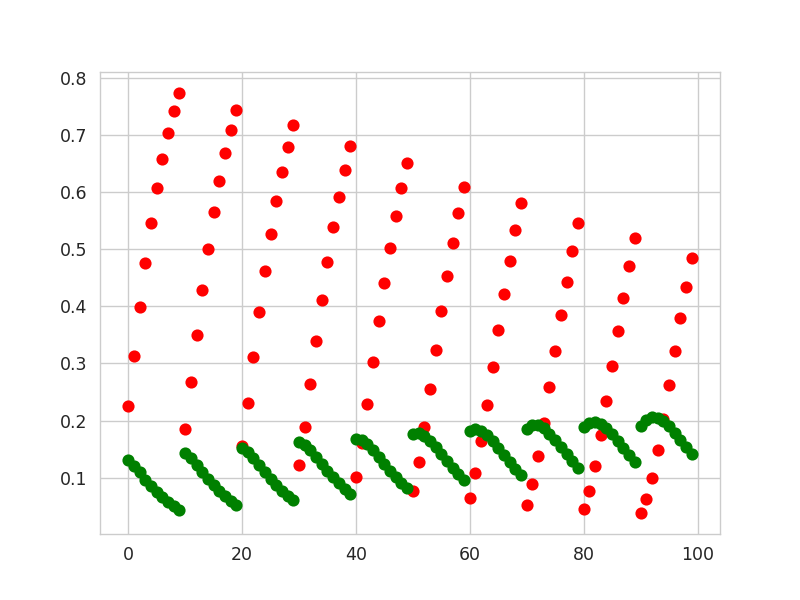

[0.35705725 0.43419294 0.50725025 0.57326961 0.6312362  0.68126575
 0.72402793 0.76040114 0.79128749 0.81752462 0.32834548 0.40142054
 0.47293776 0.53924977 0.59866803 0.65078885 0.69592639 0.73473416
 0.76798174 0.79643524 0.30717677 0.37591823 0.44514864 0.51084718
 0.5708262  0.62424077 0.67107357 0.71175102 0.7468972  0.77719066
 0.28401407 0.3466321  0.41207379 0.47610896 0.53604411 0.59051202
 0.63906686 0.68182127 0.71918566 0.75170124 0.26962781 0.32727629
 0.38918523 0.45121356 0.5104294  0.56513067 0.61455797 0.6585736
 0.69740504 0.73146775 0.25383433 0.30484132 0.36156818 0.42024347
 0.47779813 0.53218125 0.58225355 0.62754778 0.66803573 0.70394775
 0.24559382 0.29242003 0.34559025 0.40171511 0.45775959 0.51152345
 0.56165826 0.60749462 0.64883624 0.68578496 0.23809263 0.28031516
 0.32921395 0.38198252 0.43577247 0.48831408 0.53807323 0.58416895
 0.62621263 0.66414956 0.23371211 0.2727796  0.31852575 0.36863236
 0.42047499 0.47180382 0.52099266 0.5670269  0.60938342 0.64789

<IPython.core.display.Javascript object>


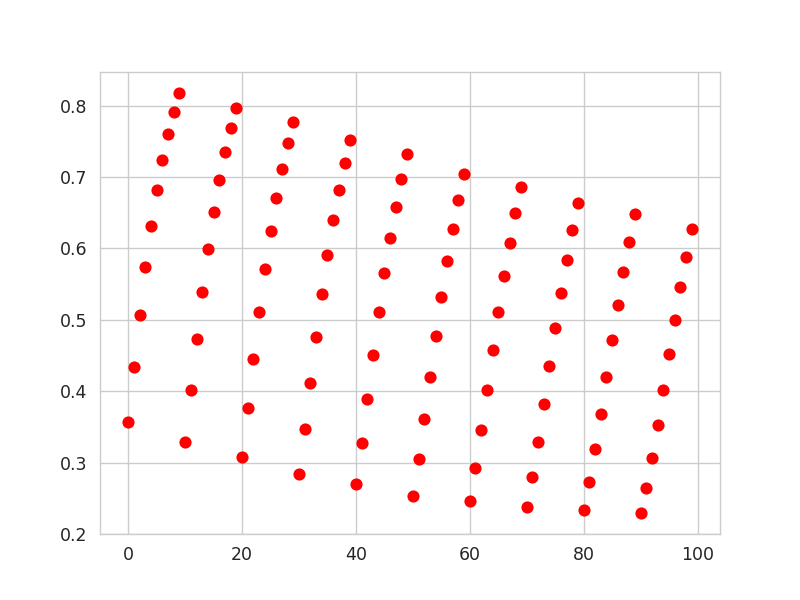

In [101]:
# Choice random point, show how it going converge.
print(W_Gau_0th_vari[:, :, 1000])
print(W_Gau_1st_vari[:, :, 1000])

# Distance of 0th moment to its target value 1
W0th_abs = np.reshape(abs(W_Gau_0th_vari[:, :, 10000] - 1), Trunc_rn * hn)
# 1st moment
W1st = np.reshape(W_Gau_1st_vari[:, :, 10000], Trunc_rn * hn)

orderr = np.linspace(0, Trunc_rn * hn - 1, Trunc_rn * hn)
plt.figure()
plt.scatter(orderr, W0th_abs, c = 'r')
plt.scatter(orderr, W1st, c = 'g')

# The distance between 2 moment to target value(0 and 1)
Choice = W0th_abs + W1st
print(Choice)

plt.figure()
plt.scatter(orderr, Choice, c = 'r')

In [102]:
# Chioce the 0th and 1st moment parameter that are the most close to the 
# target value

W_Gau_0th_fix = np.zeros(Q_length)
W_Gau_1st_fix = np.zeros(Q_length)
Trunc_r_fix = np.zeros(Q_length)
Distance_r_fix_index = np.zeros(Q_length)
h_fix = np.zeros(Q_length)

for j in range(Q_length):

    W0th_abs = np.reshape(abs(W_Gau_0th_vari[:, :, j] - 1), Trunc_rn * hn)
    W1st = np.reshape(W_Gau_1st_vari[:, :, j], Trunc_rn * hn)
    Choice = W0th_abs + W1st

    MCT = np.zeros((3, 2))
    MCT_Weighted = np.zeros((3, 1))
    for i in range(3):
        MCT[i, 0] = min(Choice)
        MCT[i, 1] = Choice.argmin()
        Choice[int(MCT[i, 1])] = Choice[int(MCT[0, 1])] + 1

    for i in range(3):  
        MCT_Weighted[i, 0] = MCT[i, 0] * (MCT[i, 1] / 100)

    MCT_0 = min(MCT_Weighted[:, 0])
    MCT_Weighted_index = MCT_Weighted[:, 0].argmin()

    MCT_0_index = MCT[MCT_Weighted_index, 1]

    MCT_index_row = int(MCT_0_index // 10)
    MCT_index_column = int(MCT_0_index % 10)
    
    # Randomly pick a point and see its PDF for a slance check.
    W_Gau_0th_fix[j] = W_Gau_0th_vari[MCT_index_row, MCT_index_column, 1000]
    W_Gau_1st_fix[j] = W_Gau_1st_vari[MCT_index_row, MCT_index_column, 1000]
    Trunc_r_fix[j] = Trunc_r_range[MCT_index_row]
    
    # Two key paremeters, will use in kernel derivateve
    Distance_r_fix_index[j] = MCT_index_row
    h_fix[j] = h_range[MCT_index_column]
    

64000
[0.92725457 0.92725457 0.92725457 ... 0.92725457 0.92725457 0.92725457]


<IPython.core.display.Javascript object>


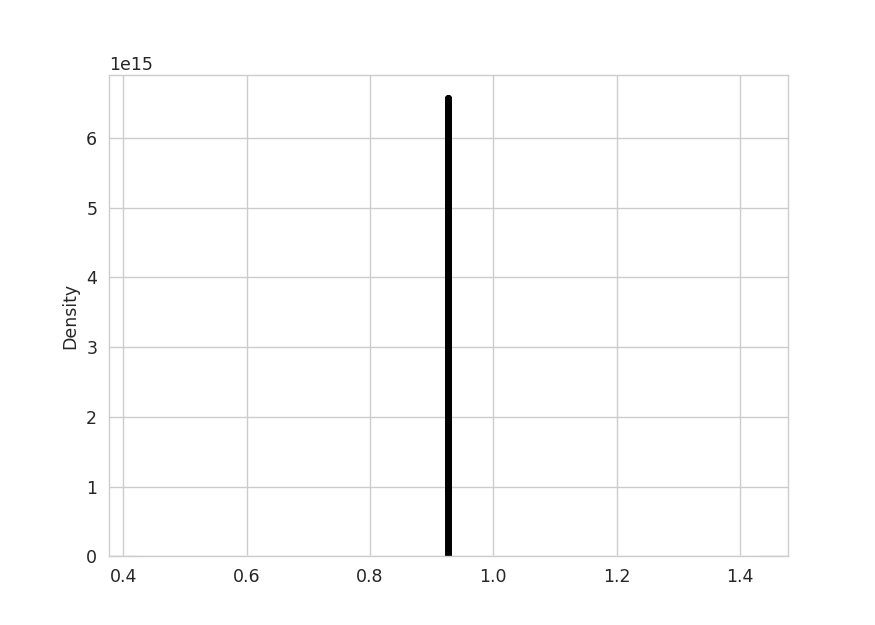

64000
[0.18200403 0.18200403 0.18200403 ... 0.18200403 0.18200403 0.18200403]


/tmp/ipykernel_8383/1255621865.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = df["AGW"]   ,  bins = 10 , kde = True , color = 'teal'


<IPython.core.display.Javascript object>


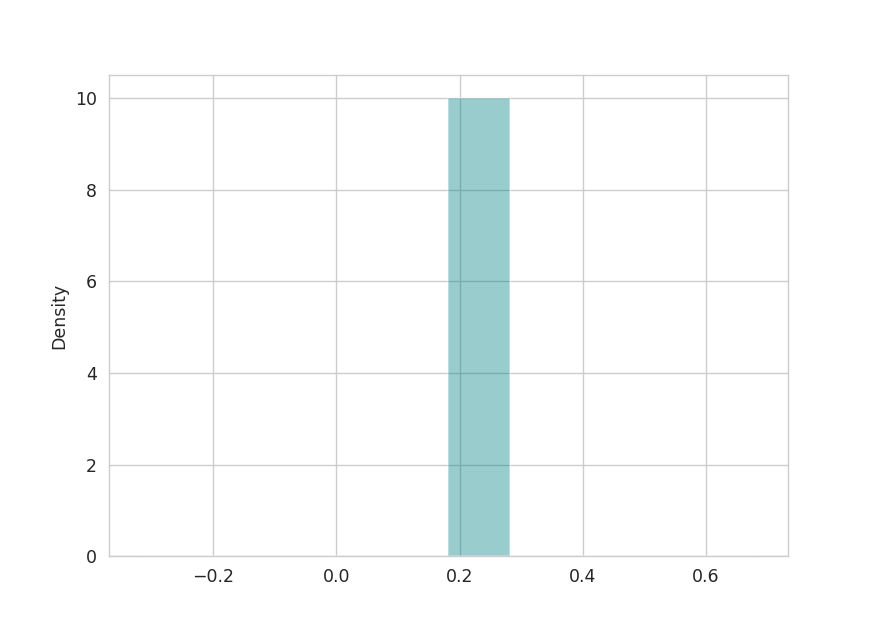

/tmp/ipykernel_8383/1255621865.py:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = df["AGW"]   ,  bins = 10 , kde = True , color = 'teal'
/home/kukup/anaconda3/envs/PyTLAB3.8/lib/python3.8/site-packages/seaborn/distributions.py:2511: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


In [103]:
# 0th moment in choicen point
n = 40
print(len(W_Gau_0th_fix))
a = W_Gau_0th_fix
a = a.reshape(1, n**3)
print(a[0])

x = a[0]  #Generating Data
source = {"Genotype": ["CV1"] * len(x), "AGW": x}
df=pd.DataFrame(source) #Converting to pandas DataFrame

sns.set_style("whitegrid")  # Setting style(Optional)
plt.figure(figsize = (7,5)) #Specify the size of figure
sns.distplot(x = df["AGW"]   ,  bins = 10 , kde = True , color = 'teal'
            , kde_kws=dict(linewidth = 4 , color = 'black')) #kde for normal distribution
plt.show()

# 1st moment in choicen point
print(len(W_Gau_1st_fix))
a = W_Gau_1st_fix
a = a.reshape(1, n**3)
print(a[0])

x = a[0]  #Generating Data
source = {"Genotype": ["CV1"] * len(x), "AGW": x}
df=pd.DataFrame(source) #Converting to pandas DataFrame

sns.set_style("whitegrid")  # Setting style(Optional)
plt.figure(figsize = (7,5)) #Specify the size of figure
sns.distplot(x = df["AGW"]   ,  bins = 10 , kde = True , color = 'teal'
            , kde_kws=dict(linewidth = 4 , color = 'black')) #kde for normal distribution
plt.show()

[[1.17970295 1.17759777 1.17225052 ... 4.27918332 4.54575479 4.8196203 ]]
[[1.09668175 1.09671261 1.23829853 ... 5.94336599 6.64983381 7.33947719]]


<IPython.core.display.Javascript object>


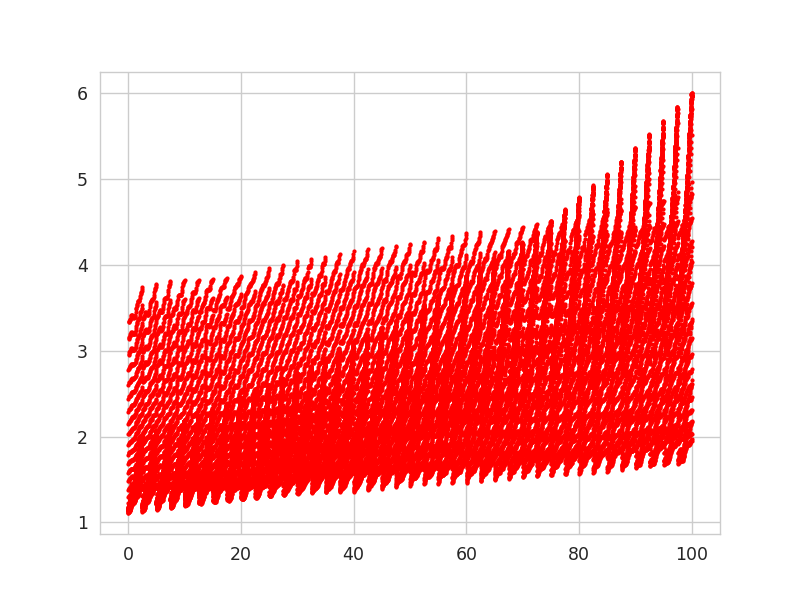

<IPython.core.display.Javascript object>


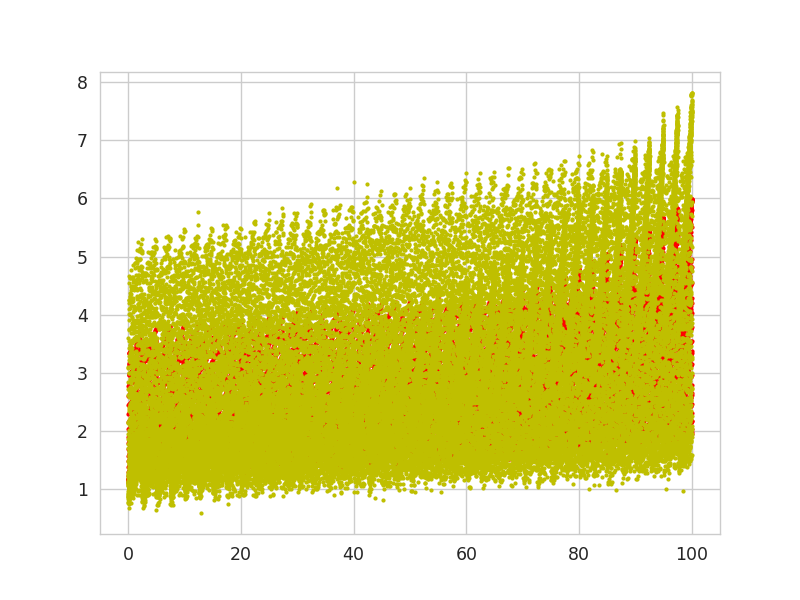

In [104]:
# Show how well the origin data out of by our smooth algorithm with choice
# parameter.

W_GauProve = np.zeros((Q_length, 1))

@jit(nopython=True)
def DistanceAllP(distance, PoinsIndex, VolVoeSubj, h, DataF):

    W_Gauij = 0
    N_Data = len(distance)
    aGau = 1 / (pow(math.pi, 1.5) * pow(h, 3))    
    for j in range(N_Data):
        
        q = distance[j] / h
        W_GauN = aGau * math.exp( -1 * math.pow(q, 2))
        W_Gauij = W_Gauij + W_GauN * VolVoeSubj[PoinsIndex[j]] * \
        DataF[PoinsIndex[j]][0]

    return(W_Gauij)

for i in range(Q_length) :
    r_index = int(Distance_r_fix_index[i])

    W_GauProve[i] = DistanceAllP(distance[r_index][i], \
                                 PoinsInd[r_index][i], \
                                 VolVoeSubj, \
                                h_fix[i], DataF)

print(W_GauProve.transpose())
print(DataF.transpose())

Inter_Plot = np.linspace(0, 100, len(W_GauProve))
Data_Plot = np.linspace(0, 100, len(DataF))
plt.figure()
plt.scatter(Inter_Plot, W_GauProve, s = 2, c = 'r')

plt.figure()
plt.scatter(Inter_Plot, W_GauProve, s = 2, c = 'r')
plt.scatter(Data_Plot, DataF, s = 2, c = 'y')

<IPython.core.display.Javascript object>


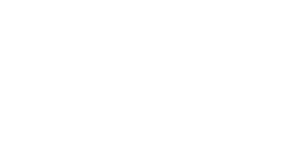

<IPython.core.display.Javascript object>


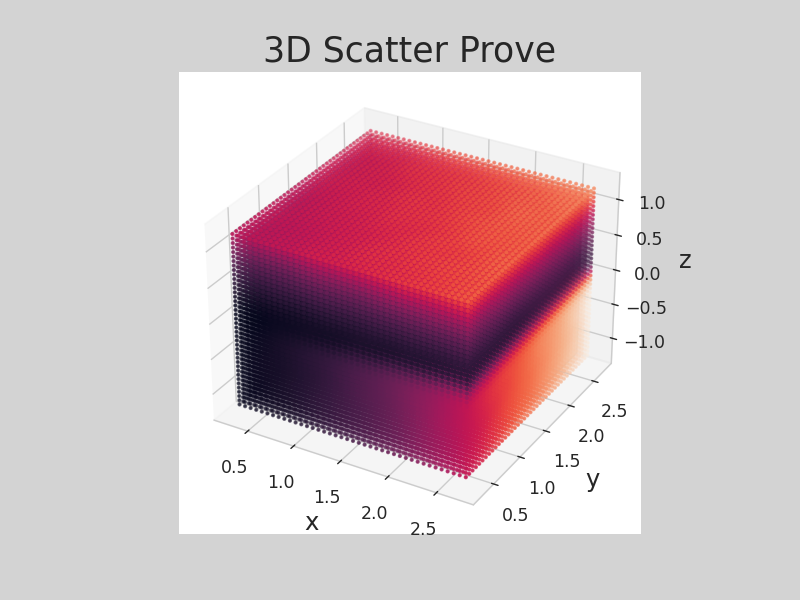

In [105]:
# Origin data in 3D

%matplotlib notebook
plt.figure("3D Scatter Ori", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('3D Scatter Ori', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)

ax3d.scatter(DataX, DataY, DataZ, c = DataF,s = 2)
plt.show()

%matplotlib notebook
plt.figure("3D Scatter Prove", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('3D Scatter Prove', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)

ax3d.scatter(x_Inter, y_Inter, z_Inter, c = W_GauProve,s = 2)
plt.show()

In [106]:
# Determine the partial derivative along each dimension

T1 = time.perf_counter()

W_GauProvePD = np.zeros((Q_length, 1))
Gauij_dev_x = np.zeros((Q_length, 1))
Gauij_dev_y = np.zeros((Q_length, 1))
Gauij_dev_z = np.zeros((Q_length, 1))
Gx = np.zeros((Q_length, 1)) 

@jit(nopython=True)
def PD_fix(distance, PoinsIndex, VolVoeSubj, h, DataF, DataX, DataY, \
                                 DataZ, x_Inter, y_Inter, z_Inter):
    W_Gauij = 0
    Gauij_dev_x = 0
    Gauij_dev_y = 0
    Gauij_dev_z = 0
    
    N_Data = len(distance)
    aGau = 1 / (pow(math.pi, 1.5) * (h ** 3))    
    for j in range(N_Data):
        
        q = distance[j] / h
        W_GauN = aGau * math.exp( -1 * math.pow(q, 2))
        W_Gauij = W_Gauij + W_GauN * VolVoeSubj[PoinsIndex[j]] * \
        DataF[PoinsIndex[j]][0]
        
        dx = (x_Inter - DataX[PoinsIndex[j]]) / distance[j]
        dy = (y_Inter - DataY[PoinsIndex[j]]) / distance[j]
        dz = (z_Inter - DataZ[PoinsIndex[j]]) / distance[j]

#         dx = distance[j] / (x_Inter - DataX[PoinsIndex[j]])
#         dy = distance[j] / (y_Inter - DataY[PoinsIndex[j]])
#         dz = distance[j] / (z_Inter - DataZ[PoinsIndex[j]])
        
        Gau_dev_x = dx * aGau * \
        math.exp(-1 * q * q) * (-2 * distance[j] / (h * h))
        
        Gauij_dev_x = Gauij_dev_x + Gau_dev_x[0] * \
        VolVoeSubj[PoinsIndex[j]] * DataF[PoinsIndex[j]][0]  

        Gau_dev_y = dy * aGau * \
        math.exp(-1 * q * q) * (-2 * distance[j] / (h * h))
        
        Gauij_dev_y = Gauij_dev_y + Gau_dev_y[0] * \
        VolVoeSubj[PoinsIndex[j]] * DataF[PoinsIndex[j]][0] 
        
        Gau_dev_z = dz * aGau * \
        math.exp( -1 * q * q) * (-2 * distance[j] / (h * h))
        
        Gauij_dev_z = Gauij_dev_z + Gau_dev_z[0] * \
        VolVoeSubj[PoinsIndex[j]] * DataF[PoinsIndex[j]][0] 
        
    return(W_Gauij, Gauij_dev_x, Gauij_dev_y, Gauij_dev_z)


for i in range(Q_length) :
    r_index = int(Distance_r_fix_index[i])

    W_GauProvePD[i], Gauij_dev_x[i], Gauij_dev_y[i], Gauij_dev_z[i]  = \
    PD_fix(distance[r_index][i], PoinsInd[r_index][i], \
                                 VolVoeSubj, h_fix[i], DataF, DataX, DataY, \
                                 DataZ, x_Inter[i], y_Inter[i], z_Inter[i])

T2 = time.perf_counter()
print(T2 - T1)

6.378240592996008


In [107]:
import copy
lenDD = len(Gauij_dev_x)

DD1 = copy.deepcopy(Gauij_dev_x)
DD2 = copy.deepcopy(Gauij_dev_y)
DD3 = copy.deepcopy(Gauij_dev_z)

LastEigenvector = np.zeros((lenDD, 3))
LastEigenvectorABS = np.zeros((lenDD, 3))
for i in range(lenDD):
# for i in range(1):

    pFpi = np.vstack((DD1[i], DD2[i], DD3[i]))
#     print(pFpi)
#     WW = np.outer(pFpi, pFpi.transpose())
    WW = np.dot(pFpi, pFpi.transpose())
#     print(WW)
    Eigenvalues, Eigenvectors = np.linalg.eig(WW)
#     print(Eigenvalues)
#     print(Eigenvectors)
    EigneValue_MaxIndex = Eigenvalues.argmax()
#     print('Max index is: ', EigneValue_MaxIndex)
    vesSwitch = Eigenvectors[:, EigneValue_MaxIndex]
#     print(vesSwitch)
    
    LastEigenvectorABS[i, 0] = abs(vesSwitch[0])
    LastEigenvectorABS[i, 1] = abs(vesSwitch[1])
    LastEigenvectorABS[i, 2] = abs(vesSwitch[2])
#     print(LastEigenvectorABS)
    
EigenFrame = pd.DataFrame({'Ev_x':LastEigenvectorABS[:, 0], \
                           'Ev_y':LastEigenvectorABS[:, 1], \
                          'Ev_z':LastEigenvectorABS[:, 2]})
EigenFrame.to_csv("Eigenvector.csv", index = False, sep = ',')

PD_data = np.vstack((LastEigenvectorABS[:, 0].transpose(), \
                     LastEigenvectorABS[:, 1].transpose(), \
                   LastEigenvectorABS[:, 2].transpose()))

<IPython.core.display.Javascript object>


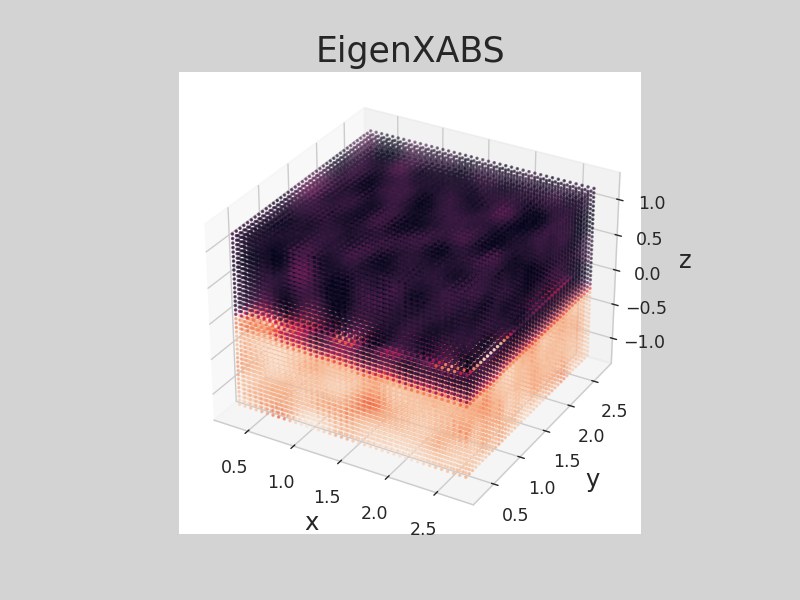

<IPython.core.display.Javascript object>


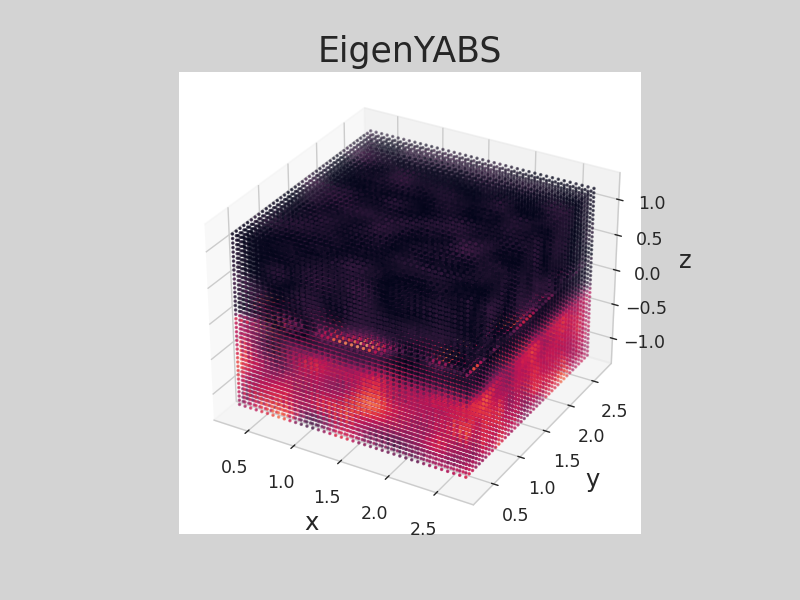

<IPython.core.display.Javascript object>


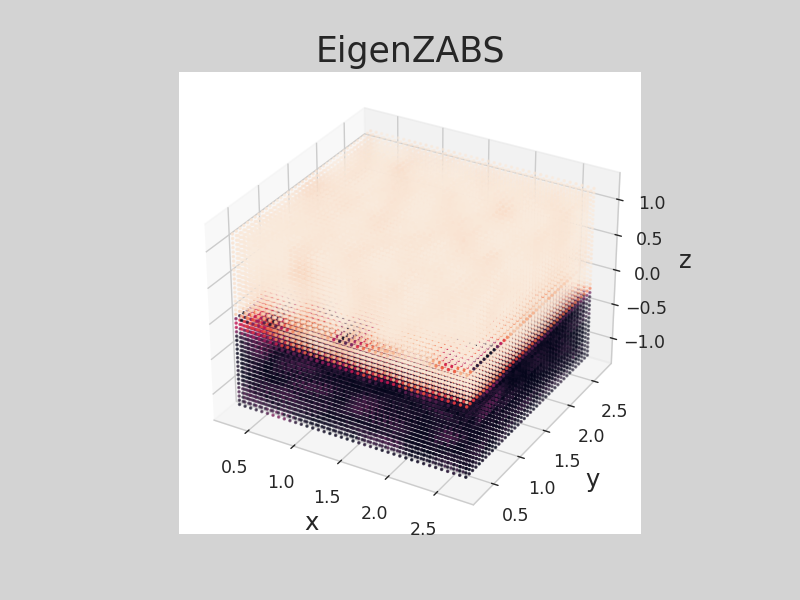

In [108]:
plt.figure("EigenXABS", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('EigenXABS', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(x_Inter, y_Inter, z_Inter, c = LastEigenvectorABS[:, 0], s = 1)
plt.show()

plt.figure("EigenYABS", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('EigenYABS', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(x_Inter, y_Inter, z_Inter, c = LastEigenvectorABS[:, 1], s = 1)
plt.show()

plt.figure("EigenZABS", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('EigenZABS', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(x_Inter, y_Inter, z_Inter, c = LastEigenvectorABS[:, 2], s = 1)
plt.show()

<IPython.core.display.Javascript object>


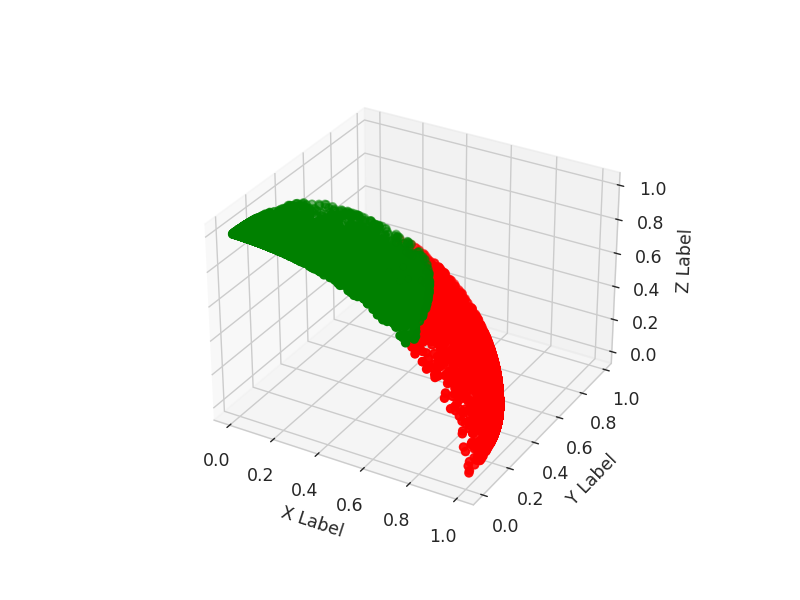

In [110]:
import numpy as np
from sklearn.cluster import KMeans

class FuzzyKMeans3D:

    def __init__(self, n_clusters=8, m=2, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.tol = tol
        
    def fit(self, X):
        # Clusting center points
        kmeans = KMeans(n_clusters=self.n_clusters, max_iter=self.max_iter, tol=self.tol)
        kmeans.fit(X)
        centers = kmeans.cluster_centers_
        
        # Initialise belonging metrix
        n_samples = X.shape[0]
        U = np.random.rand(n_samples, self.n_clusters)
        U /= np.sum(U, axis=1)[:, None]
        
        # Iterate belonging metrix and center points
        for i in range(self.max_iter):
            # Update Belongingbility
            distances = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
            U_new = 1 / distances ** (2 / (self.m - 1))
            U_new /= np.sum(U_new, axis=1)[:, None]
            
            # Check if converge
            if np.allclose(U, U_new, rtol=self.tol):
                break
                
            U = U_new
            
            # Update centers
            centers = np.dot(U.T, X) / np.sum(U, axis=0)[:, None]
        
        # Return
        labels = np.argmax(U, axis=1)
        return centers, labels, U

    
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

PD_data = PD_data.transpose()

fkm = FuzzyKMeans3D(n_clusters = 2)
centers, labels, U = fkm.fit(PD_data)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g']
for i in range(fkm.n_clusters):
    ax.scatter(PD_data[labels == i, 0], PD_data[labels == i, 1], \
               PD_data[labels == i, 2], color=colors[i])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [111]:
print(U)
UMetrix = pd.DataFrame({'U1':U[:, 0], \
                           'U2':U[:, 1]})
UMetrix.to_csv("GoodU.csv", index = False, sep = ',')

[[0.99197364 0.00802636]
 [0.99501583 0.00498417]
 [0.9982383  0.0017617 ]
 ...
 [0.00636343 0.99363657]
 [0.00401994 0.99598006]
 [0.00491287 0.99508713]]


<IPython.core.display.Javascript object>


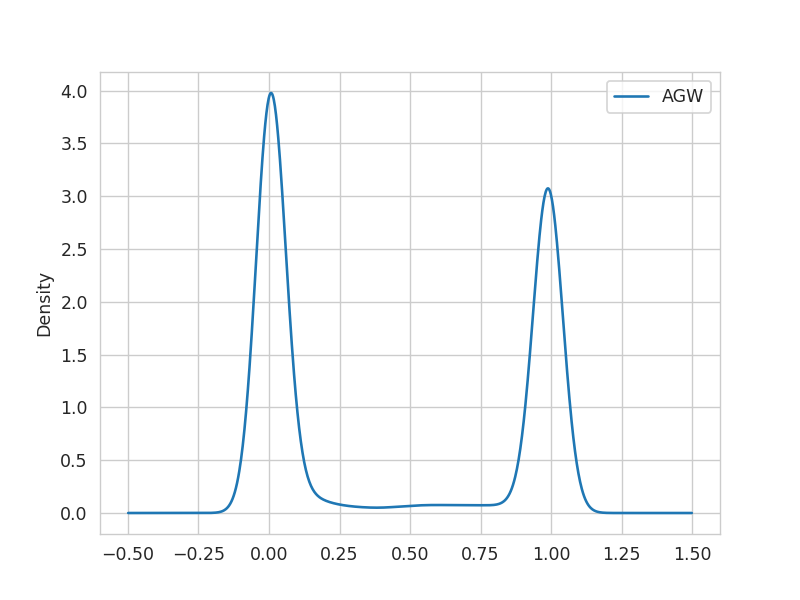

<IPython.core.display.Javascript object>


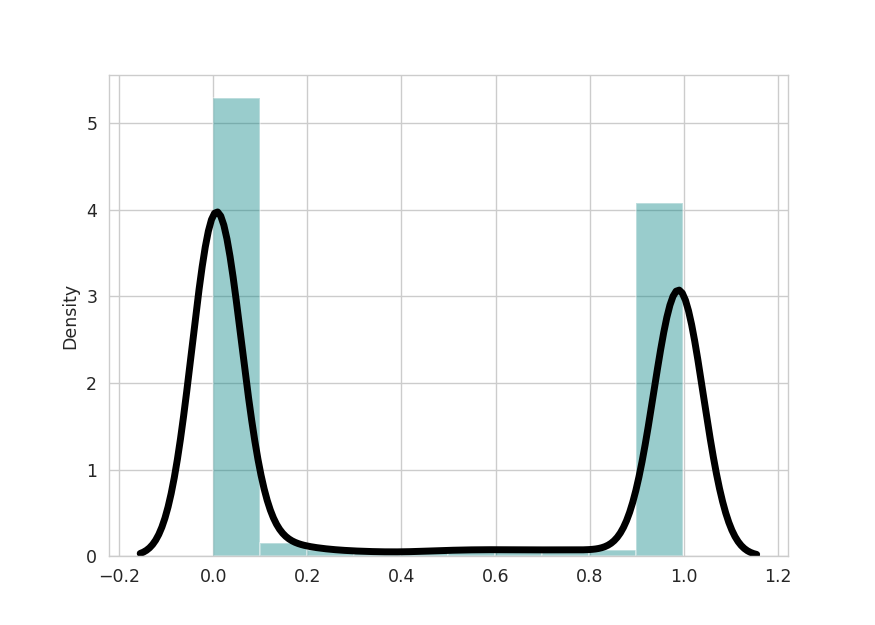

/tmp/ipykernel_8383/3779149449.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = df["AGW"], bins = 10 , kde = True , color = 'teal'


In [112]:
x = U[:, 0]  #Generating Data
source = {"Genotype": ["CV1"] * len(x), "AGW": x}
df=pd.DataFrame(source) #Converting to pandas DataFrame
df.plot(kind = 'density'); # or df["AGW"].plot(kind = 'density');

sns.set_style("whitegrid")  # Setting style(Optional)
plt.figure(figsize = (7,5)) #Specify the size of figure 
sns.distplot(x = df["AGW"], bins = 10 , kde = True , color = 'teal'
            , kde_kws=dict(linewidth = 4 , color = 'black')) #kde for normal distribution
plt.show()

In [113]:
X_Inter_Clustering_R1 = []
Y_Inter_Clustering_R1 = []
Z_Inter_Clustering_R1 = []
X_Inter_Clustering_R2 = []
Y_Inter_Clustering_R2 = []
Z_Inter_Clustering_R2 = []

X_Dev_Clustering_R1 = []
Y_Dev_Clustering_R1 = []
Z_Dev_Clustering_R1 = []
X_Dev_Clustering_R2 = []
Y_Dev_Clustering_R2 = []
Z_Dev_Clustering_R2 = []
for i in range(len(U)):
    if U[i, 0] < 0.2:
        X_Inter_Clustering_R1.append(x_Inter[i])
        Y_Inter_Clustering_R1.append(y_Inter[i])
        Z_Inter_Clustering_R1.append(z_Inter[i])
        X_Dev_Clustering_R1.append(PD_data[i, 0])
        Y_Dev_Clustering_R1.append(PD_data[i, 1])
        Z_Dev_Clustering_R1.append(PD_data[i, 2])
    if U[i, 0] > 0.8:
        X_Inter_Clustering_R2.append(x_Inter[i])
        Y_Inter_Clustering_R2.append(y_Inter[i])
        Z_Inter_Clustering_R2.append(z_Inter[i])
        X_Dev_Clustering_R2.append(PD_data[i, 0])
        Y_Dev_Clustering_R2.append(PD_data[i, 1])
        Z_Dev_Clustering_R2.append(PD_data[i, 2])

In [114]:
print(len(X_Inter_Clustering_R1) + len(X_Inter_Clustering_R2))

61419


<IPython.core.display.Javascript object>


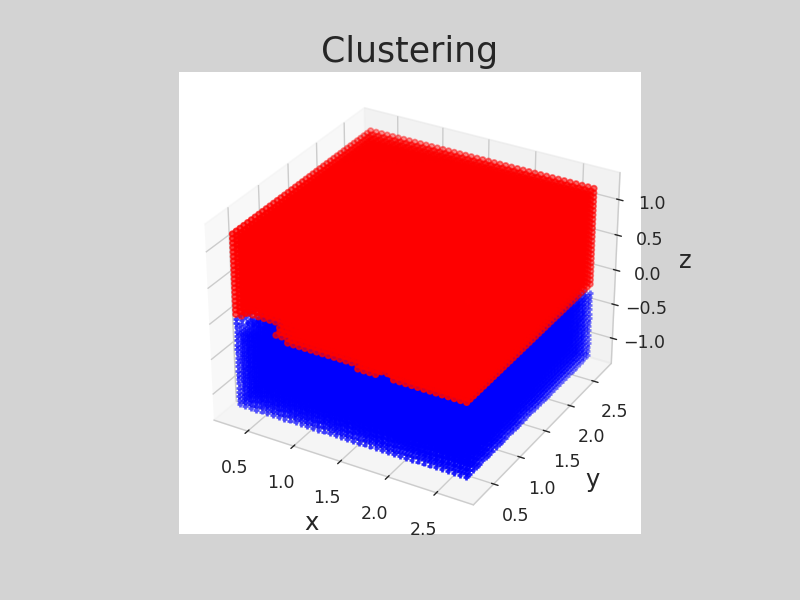

In [115]:
%matplotlib notebook
plt.figure("Clustering", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('Clustering', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(X_Inter_Clustering_R1, Y_Inter_Clustering_R1,\
            Z_Inter_Clustering_R1, marker='o', color='r', \
            label = '0', s = 10)
ax3d.scatter(X_Inter_Clustering_R2, Y_Inter_Clustering_R2, \
            Z_Inter_Clustering_R2, marker='+', color='b', \
            label = '1', s = 10)

plt.show()


<IPython.core.display.Javascript object>


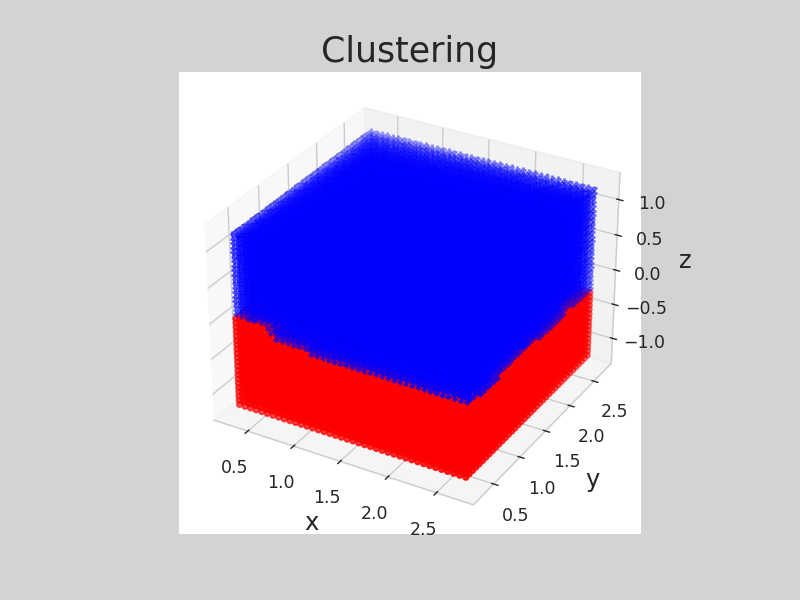

In [116]:
%matplotlib notebook
plt.figure("Clustering", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('Clustering', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(x_Inter[labels == 0], y_Inter[labels == 0],\
            z_Inter[labels == 0], marker='o', color='r', \
            label = '0', s = 10)
ax3d.scatter(x_Inter[labels == 1], y_Inter[labels == 1], \
            z_Inter[labels == 1], marker='+', color='b', \
            label = '1', s = 10)

plt.show()


In [117]:
# CoordRegionA = pd.DataFrame({'x':x_Inter[labels == 0].ravel(), \
#                            'y':y_Inter[labels == 0].ravel(), \
#                           'z':z_Inter[labels == 0].ravel()})
# CoordRegionA.to_csv("CoordRegionA.csv", index = False, sep = ',')

# CoordRegionB = pd.DataFrame({'x':x_Inter[labels == 1].ravel(), \
#                            'y':y_Inter[labels == 1].ravel(), \
#                           'z':z_Inter[labels == 1].ravel()})
# CoordRegionB.to_csv("CoordRegionB.csv", index = False, sep = ',')

In [118]:
import copy
RegionA_dev_x = copy.deepcopy(PD_data[labels == 0, 0])
RegionA_dev_y = copy.deepcopy(PD_data[labels == 0, 1])
RegionA_dev_z = copy.deepcopy(PD_data[labels == 0, 2])

RegionB_dev_x = copy.deepcopy(PD_data[labels == 1, 0])
RegionB_dev_y = copy.deepcopy(PD_data[labels == 1, 1])
RegionB_dev_z = copy.deepcopy(PD_data[labels == 1, 2])

EigenRegionA = pd.DataFrame({'Ev_x':RegionA_dev_x, \
                           'Ev_y':RegionA_dev_y, \
                          'Ev_z':RegionA_dev_z})
EigenRegionA.to_csv("EigenRegionA.csv", index = False, sep = ',')

EigenRegionB = pd.DataFrame({'Ev_x':RegionB_dev_x, \
                           'Ev_y':RegionB_dev_y, \
                          'Ev_z':RegionB_dev_z})
EigenRegionB.to_csv("EigenRegionB.csv", index = False, sep = ',')

In [119]:

RegionA_len = len(RegionA_dev_x)
RegionB_len = len(RegionB_dev_x)
print(RegionA_len, RegionB_len)

Sum_RegionA = np.zeros((3, 3))
Sum_RegionB = np.zeros((3, 3))

for i in range(RegionA_len):

    pFpi_RegionA = np.vstack((RegionA_dev_x[i], RegionA_dev_y[i], \
                              RegionA_dev_z[i]))
    WW_RegionA = np.dot(pFpi_RegionA, pFpi_RegionA.transpose())
    Sum_RegionA = Sum_RegionA + WW_RegionA
    
Eigenvalues_RegionA, Eigenvectors_RegionA = np.linalg.eig(Sum_RegionA)
EigneValue_MaxIndex_RegionA = Eigenvalues_RegionA.argmax()
vesSwitch_RegionA = Eigenvectors_RegionA[:, EigneValue_MaxIndex_RegionA]
Coord_RegionA = abs(vesSwitch_RegionA)
    
for i in range(RegionB_len):

    pFpi_RegionB = np.vstack((RegionB_dev_x[i], RegionB_dev_y[i], \
                              RegionB_dev_z[i]))
    WW_RegionB = np.dot(pFpi_RegionB, pFpi_RegionB.transpose())
    Sum_RegionB = Sum_RegionB + WW_RegionB

Eigenvalues_RegionB, Eigenvectors_RegionB = np.linalg.eig(Sum_RegionB)
EigneValue_MaxIndex_RegionB = Eigenvalues_RegionB.argmax()
vesSwitch_RegionB = Eigenvectors_RegionB[:, EigneValue_MaxIndex_RegionB]
Coord_RegionB = abs(vesSwitch_RegionB)

print('Ra: ', Coord_RegionA, '\n', 'Rb: ', Coord_RegionB)

print(EigneValue_MaxIndex_RegionA)

print(Eigenvectors_RegionA)

print(EigneValue_MaxIndex_RegionB)

print(Eigenvectors_RegionB)

28004 35996
Ra:  [0.8915835  0.43915787 0.11054057] 
 Rb:  [0.1555432  0.08272801 0.98435887]
0
[[ 0.8915835   0.44585459 -0.07932554]
 [ 0.43915787 -0.89400359 -0.08887036]
 [ 0.11054057 -0.04439891  0.99287941]]
0
[[-0.1555432  -0.89888102  0.40965745]
 [-0.08272801 -0.40139456 -0.91216144]
 [-0.98435887  0.17577065  0.01192844]]


In [120]:
RegionA_len = len(X_Dev_Clustering_R1)
RegionB_len = len(X_Dev_Clustering_R2)
print(RegionA_len, RegionB_len)

Sum_RegionA = np.zeros((3, 3))
Sum_RegionB = np.zeros((3, 3))

for i in range(RegionA_len):

    pFpi_RegionA = np.vstack((X_Dev_Clustering_R1[i], Y_Dev_Clustering_R1[i], \
                              Z_Dev_Clustering_R1[i]))
    WW_RegionA = np.dot(pFpi_RegionA, pFpi_RegionA.transpose())
    Sum_RegionA = Sum_RegionA + WW_RegionA
    
Eigenvalues_RegionA, Eigenvectors_RegionA = np.linalg.eig(Sum_RegionA)
EigneValue_MaxIndex_RegionA = Eigenvalues_RegionA.argmax()
vesSwitch_RegionA = Eigenvectors_RegionA[:, EigneValue_MaxIndex_RegionA]
Coord_RegionA = abs(vesSwitch_RegionA)
    
for i in range(RegionB_len):

    pFpi_RegionB = np.vstack((X_Dev_Clustering_R2[i], Y_Dev_Clustering_R2[i], \
                              Z_Dev_Clustering_R2[i]))
    WW_RegionB = np.dot(pFpi_RegionB, pFpi_RegionB.transpose())
    Sum_RegionB = Sum_RegionB + WW_RegionB

Eigenvalues_RegionB, Eigenvectors_RegionB = np.linalg.eig(Sum_RegionB)
EigneValue_MaxIndex_RegionB = Eigenvalues_RegionB.argmax()
vesSwitch_RegionB = Eigenvectors_RegionB[:, EigneValue_MaxIndex_RegionB]
Coord_RegionB = abs(vesSwitch_RegionB)

print('Ra: ', Coord_RegionA, '\n', 'Rb: ', Coord_RegionB)

print(EigneValue_MaxIndex_RegionA)

print(Eigenvectors_RegionA)

print(EigneValue_MaxIndex_RegionB)

print(Eigenvectors_RegionB)

34843 26576
Ra:  [0.14315456 0.07652194 0.98673764] 
 Rb:  [0.89375742 0.43995601 0.08738639]
0
[[-0.14315456 -0.91277917  0.38254537]
 [-0.07652194 -0.37516117 -0.9237957 ]
 [-0.98673764  0.16151868  0.0161416 ]]
0
[[-0.89375742 -0.41961427 -0.15849775]
 [-0.43995601  0.88892048  0.12751116]
 [-0.08738639 -0.18369608  0.97909109]]
